### Data Loading and Preprocessing

- **Objective**: Load and preprocess image data for classification.
- **Steps**:
  1. **Image Loading Function**:
     - The `load_images_from_folder()` function iterates through a specified dataset directory.
     - It assumes that each class of images is stored in its own subfolder.
     - Images are resized to a target size of 64x64 pixels and flattened into a 1D array.
     - Corresponding labels are extracted from subfolder names.
  2. **Dataset Path**:
     - The dataset folder is specified with the path 
  3. **Label Encoding**:
     - Class labels are encoded into numeric values using `LabelEncoder` from scikit-learn.
  4. **Train-Test Split**:
     - The dataset is split into training (80%) and testing (20%) subsets.
     - Stratified splitting ensures class distribution is preserved in both subsets.


In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

def load_images_from_folder(folder, size=(64, 64)):
    """
    Load images from a directory. Assumes each class has its own subfolder.
    :param folder: Main dataset directory
    :param size: Tuple indicating target image size (e.g., (64, 64))
    :return: Flattened images and corresponding labels
    """
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = Image.open(img_path) #.convert('L')  # Convert to grayscale
            img = img.resize(size)
            images.append(np.array(img).flatten())  # Flatten the image
            labels.append(label_folder)
    return np.array(images), np.array(labels)

# Specify dataset folder and load data
dataset_folder = "/Users/abdulr/Desktop/Abdul/F20Dl/data/plantdata"  # Change this to your dataset path
X, y = load_images_from_folder(dataset_folder)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train-Test Split Verification:")
print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")

Train-Test Split Verification:
Training samples: 46839, Testing samples: 11710


### Feature Scaling and Cross-Validation for k-NN

- **Objective**: Scale the features to normalize pixel intensity values and evaluate the k-NN model using cross-validation.

- **Steps**:
  1. **Feature Scaling**:
     - The `StandardScaler` is applied to normalize the feature values.
     - The training data (`X_train`) is fitted and transformed, and the test data (`X_test`) is transformed using the same scaler.
  2. **Initialize k-NN Classifier**:
     - A k-NN classifier is initialized with default parameters.
  3. **Cross-Validation**:
     - The `cross_val_score` function is used to perform 5-fold cross-validation on the scaled training data.
     - Cross-validation evaluates the model’s accuracy on different subsets of the training data, providing a more robust assessment.
  4. **Output Results**:
     - Cross-validation accuracy scores are printed for each fold.
     - The mean accuracy and the standard deviation of accuracy across folds are computed and displayed.

- **Output**:
  - Cross-validation accuracy scores for each fold.
  - Mean cross-validation accuracy.
  - Standard deviation of accuracy across folds.

In [4]:
# Normalize features (pixel intensity values)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

 Cerscospora       1.00      1.00      1.00      1536
     Healthy       1.00      1.00      1.00      3797
   Leaf rust       1.00      1.00      1.00      1667
       Miner       1.00      1.00      1.00      3396
       Phoma       1.00      1.00      1.00      1314

    accuracy                           1.00     11710
   macro avg       1.00      1.00      1.00     11710
weighted avg       1.00      1.00      1.00     11710


Cross-Validation Results:
Cross-Validation Accuracy Scores: [0.99957301 1.         0.99989325 0.99989325 0.99957297]
Mean Cross-Validation Accuracy: 99.98%
Standard Deviation of Accuracy: 0.02%


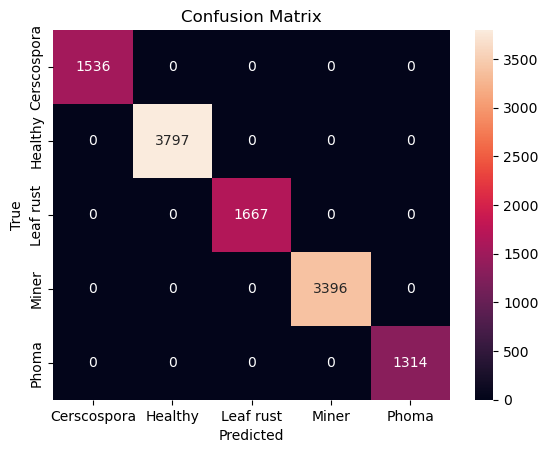

In [5]:

# Initialize k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors

# Train the k-NN model
knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)

# Output cross-validation results
print("\nCross-Validation Results:")
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")
print(f"Standard Deviation of Accuracy: {np.std(cv_scores) * 100:.2f}%")


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



### Hyperparameter Tuning and Evaluation of k-NN Using Grid Search

- **Objective**: Optimize the `n_neighbors` hyperparameter for the k-NN model using grid search, evaluate the model's performance, and visualize the results.

- **Steps**:
  1. **Define Parameter Grid**:
     - A range of possible values for `n_neighbors` is defined: `[1, 3, 5, 7, 9, 11]`.
  2. **Grid Search**:
     - `GridSearchCV` is used to perform a 3-fold cross-validation for each value of `n_neighbors` in the grid.
     - The evaluation metric is accuracy (`scoring='accuracy'`).
     - Verbose output is enabled for detailed progress monitoring.
  3. **Retrieve Best Parameters**:
     - After the grid search, the optimal value of `n_neighbors` is displayed along with the best cross-validation accuracy score.
  4. **Evaluate Best Model**:
     - The best-performing k-NN model (`best_knn`) is used to make predictions on the test set.
     - Test set accuracy is calculated and displayed.
  5. **Optional: Classification Report**:
     - A detailed classification report is printed for the best model's predictions on the test set.
  6. **Optional: Visualize Results**:
     - A plot of the cross-validation accuracy scores for each value of `n_neighbors` is generated to visualize how the model's performance varies with the hyperparameter.

- **Output**:
  - Optimal value of `n_neighbors`.
  - Best cross-validation accuracy.
  - Test set accuracy of the best model.
  - Optional: Classification report and plot of cross-validation accuracy.


In [7]:
# Define parameter grid
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11]}

# Grid search for k-NN
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best k: {grid_search.best_params_['n_neighbors']}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

# Evaluate best model on test set
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Test Set Accuracy with Best k: {best_accuracy * 100:.2f}%")


Best k: 1
Best Cross-Validation Accuracy: 100.00%
Test Set Accuracy with Best k: 100.00%


### Testing the model predictions

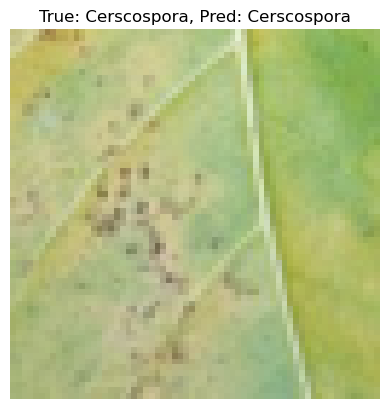

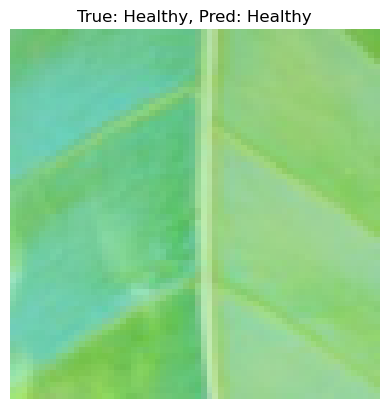

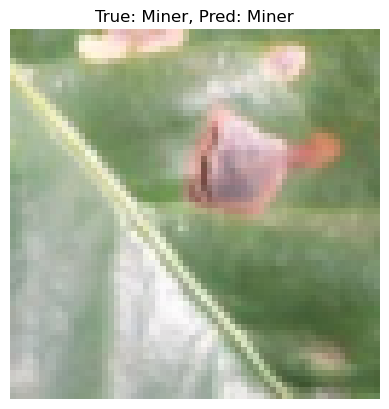

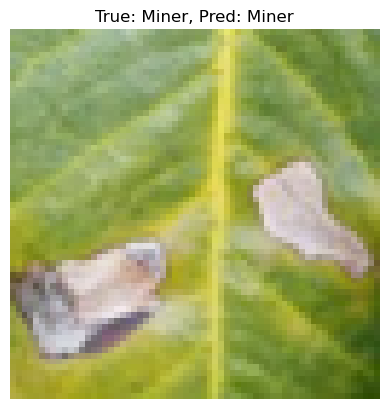

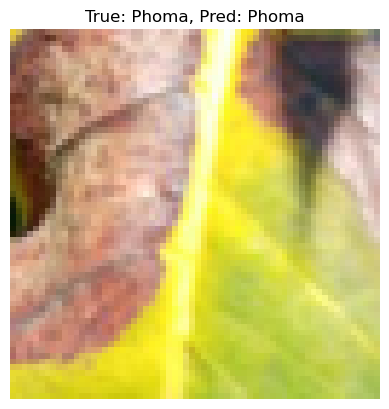

In [9]:
for i in range(5):  # Show 5 test images with predictions
    # Reshape the image back to its original shape (64, 64, 3)
    plt.imshow(X_test[i].reshape(64, 64, 3).astype('uint8'))  # Ensure uint8 type for RGB
    plt.title(f"True: {label_encoder.inverse_transform([y_test[i]])[0]}, Pred: {label_encoder.inverse_transform([y_pred[i]])[0]}")
    plt.axis('off')
    plt.show()


# Handling Data Imbalance with SMOTE


In this section, we will handle class imbalances in the dataset using SMOTE (Synthetic Minority Over-sampling Technique). 
We will also visualize the class distribution before and after applying SMOTE.


/var/folders/93/fkww6mv13m3crdyrypt44hzm0000gn/T/ipykernel_6736/2592713566.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')


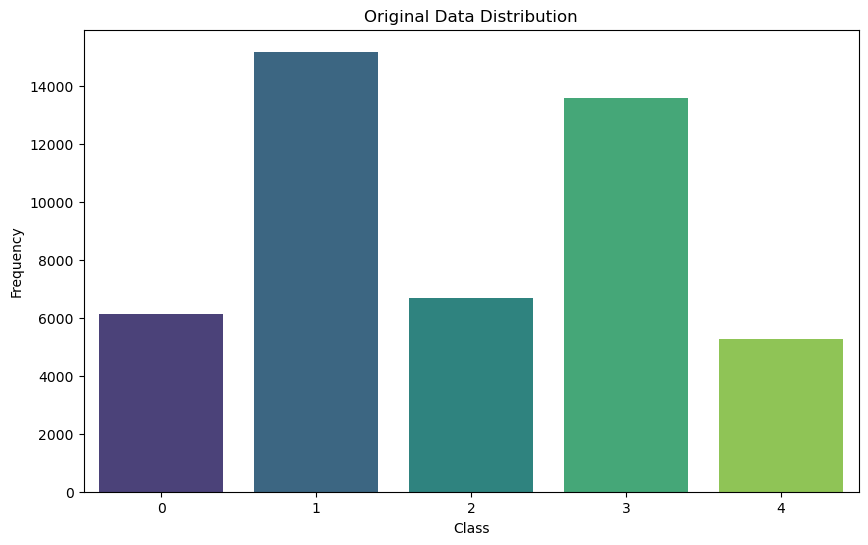

/var/folders/93/fkww6mv13m3crdyrypt44hzm0000gn/T/ipykernel_6736/2592713566.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_smote, palette='viridis')


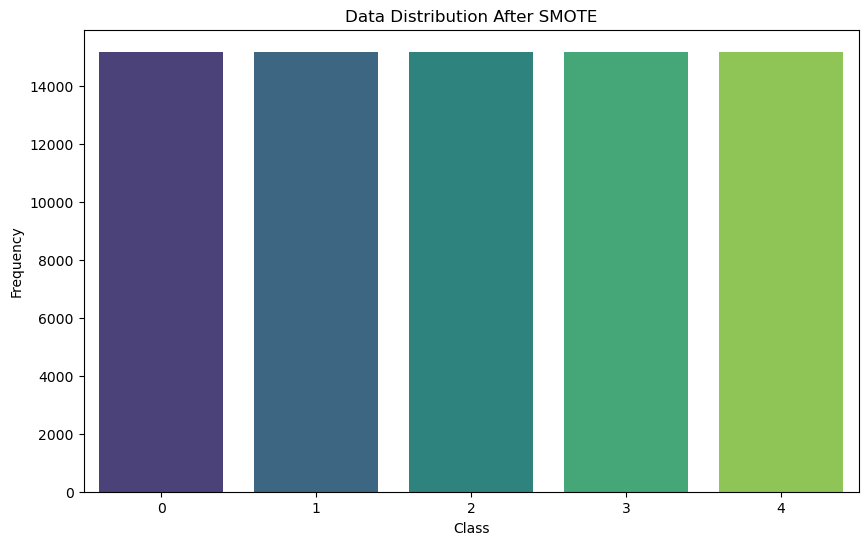

In [12]:

# Import necessary libraries for SMOTE
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the original data distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, palette='viridis')
plt.title('Original Data Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Visualize the new data distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_smote, palette='viridis')
plt.title('Data Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


## Train KNN Model with Balanced Data

In [14]:

# Train KNN model on SMOTE-balanced data
knn_smote = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the original test set
y_pred_smote = knn_smote.predict(X_test)

# Evaluate the model
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"KNN Accuracy on SMOTE-Balanced Data: {accuracy_smote:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))


KNN Accuracy on SMOTE-Balanced Data: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1536
           1       1.00      1.00      1.00      3797
           2       1.00      1.00      1.00      1667
           3       1.00      1.00      1.00      3396
           4       1.00      1.00      1.00      1314

    accuracy                           1.00     11710
   macro avg       1.00      1.00      1.00     11710
weighted avg       1.00      1.00      1.00     11710



## Confusion Matrix for SMOTE-Balanced Data

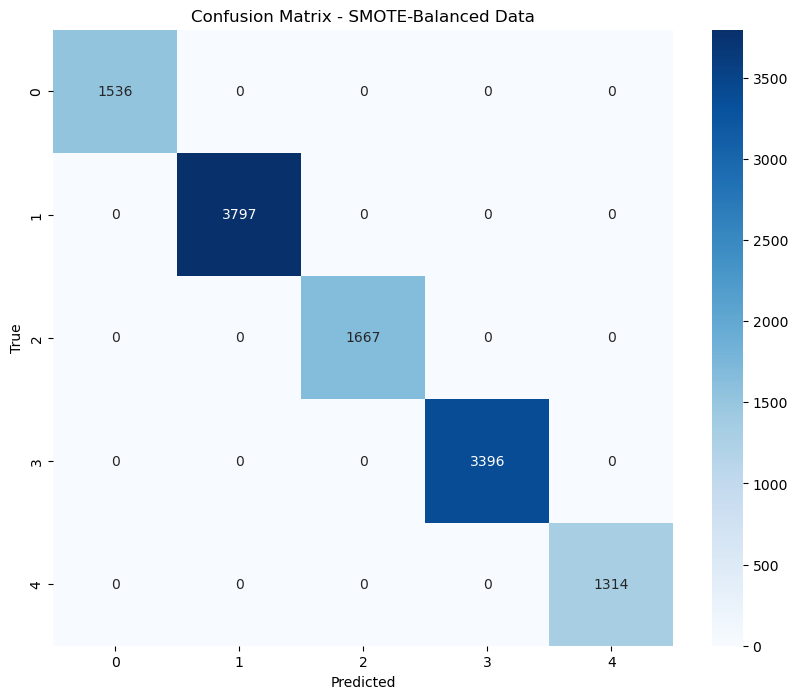

In [16]:

# Confusion matrix for SMOTE-balanced data
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SMOTE-Balanced Data')
plt.show()
